In [3]:
!wget "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
!wget "https://raw.githubusercontent.com/romenlaw/NaiveNeuralNetwork/main/tinysp_vocab_min.json"
!wget "https://raw.githubusercontent.com/romenlaw/NaiveNeuralNetwork/main/tinysp_vocab.json"

/bin/bash: line 1: 1: command not found
--2024-10-13 03:29:03--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.2’

input.txt.2         100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2024-10-13 03:29:03 (17.4 MB/s) - ‘input.txt.2’ saved [1115394/1115394]

/bin/bash: line 1: 1: command not found
--2024-10-13 03:29:03--  https://raw.githubusercontent.com/romenlaw/NaiveNeuralNetwork/main/tinysp_vocab_min.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.1

In [5]:
with open("input.txt", "r", encoding='utf-8') as f:
  text = f.read()
len(text)

1115394

In [6]:
text[:1000]

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger 

In [7]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Tokeniser

The tokeniser vocab is created in the [tokenisation notebook](https://github.com/romenlaw/NaiveNeuralNetwork/blob/main/tokenisation.ipynb) using tiny Shakespeare as input data.

There are two versions of the vocab:
* tinysp_vocab.json - created with byte pair algorithm using tiny Shakepeare as input. There are 10237 tokens.
* tinysp_vocab_min.json - same as above except that unused tokens (in tiny Shakespeare) has been removed (hence, the token integers are not contiguous). There are 8652 tokens.

In [49]:
import ast

with open("tinysp_vocab.json", "r") as f:
  input = f.read()
vocab = ast.literal_eval(input)
vocab_size = len(vocab)

In [47]:
def count_bytepairs(bytes):
  counts = {}
  for pair in zip(bytes, bytes[1:]):
    counts[pair] = counts.get(pair, 0) + 1
  counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
  return counts

def merge_bytepair(raw_bytes, pair, new_token):
  """pair is a list containing two integers, representing the utf-8 code of
  the 2 characters to be replaced
  """
  assert isinstance(pair, list) and len(pair)==2, "pair must be a list of two integers"
  for i in range(len(raw_bytes)-1, 0, -1):  # loop backwards
    #print(i-1, i)
    if raw_bytes[i-1:i+1] == pair:
      raw_bytes[i-1:i+1] = [new_token]

  return raw_bytes

num_merges = vocab_size - 256
merges = {} # build up a lookup of what has been merged into what

def encode(s, tokens=None):
  """Given a string, return a list of integers using utf-8 and byte pair
  tokens is a list of utf-8 codes or encoded byte-pair codes, updated in recursion
  """
  assert isinstance(s, str), f"expect string, but got {type(s).__name__}"
  tokens = list(s.encode("utf-8")) if tokens is None else tokens
  counts = count_bytepairs(tokens)
  # if len is too small, next(counts_iter) in below loop will fail
  # if no more duplicated byte pairs, then stop the recursion
  if len(counts) <=1 or counts[list(counts)[0]]<=1:
      return tokens

  new_token = max(tokens+[255])
  counts_iter = iter(counts.items())
  global num_merges
  #for i in range(num_merges):
  while num_merges>0:
    num_merges-=1
    new_token += 1
    pair, count = next(counts_iter)
    if count>1:
      pair_copy = list(pair)
      merge_bytepair(tokens, pair_copy, new_token)
      merges[pair] = new_token
    else:
      # if the current duplicated byte pairs are exhausted, refresh the counts
      # and continue to encode
      encode(s, tokens)
      break

  return tokens

In [48]:
def decode(ids):
  """Given a list of tokens (integers), return a python string
  """
  assert isinstance(ids, list), "ids must be list"
  assert all((isinstance(i, int) and i>=0 ) for i in ids), \
    "ids must be a list of integers in [0, vocab_size)"
#   out = bytes()
#   for b in ids:
#     out += vocab[b]
  out = b"".join(vocab[b] for b in ids)
  return out.decode("utf-8", errors='replace') # see utf-8 spec

In [45]:
print(encode("hello world with this!"))

[104, 101, 108, 108, 111, 256, 111, 114, 108, 100, 256, 105, 257, 32, 257, 105, 115, 33]


In [46]:
decode([104, 101, 108, 108, 111, 256])

'helloe '

In [51]:
decode(encode(text[:100]))

'onBeforthwthproceed any furtanrrehe r mthesAll tSpe kreesonYou'

# Dataset

In [ ]:
# let's encode our dataset
import torch
device = "cuda" if torch.cuda.is_available() else 'cpu'
data = torch.tensor(encode(text), dtype=torch.long)

In [ ]:
data.shape, data.dtype, data[:1000]

(torch.Size([1115394]),
 torch.int64,
 tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
         53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
          1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
         57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
          6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
         58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
          1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
         53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
         57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
          8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
          1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
         53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39

In [ ]:
# split dataset into training (90%) and validation (10%)
n = int(data.shape[0] * .9)
data_train = data[:n]
data_val = data[n:]

In [ ]:
data_train.shape, data_val.shape

(torch.Size([1003854]), torch.Size([111540]))

In [ ]:
block_size = 8 # context/chunk length
data_train[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [ ]:
# let's have a look at the time-dimension
x = data_train[:block_size]
y = data_train[1:block_size+1]
for i in range(block_size):
  context=x[:i+1]
  print(f"from {context}, we want to predict {y[i]}")


from tensor([18]), we want to predict 47
from tensor([18, 47]), we want to predict 56
from tensor([18, 47, 56]), we want to predict 57
from tensor([18, 47, 56, 57]), we want to predict 58
from tensor([18, 47, 56, 57, 58]), we want to predict 1
from tensor([18, 47, 56, 57, 58,  1]), we want to predict 15
from tensor([18, 47, 56, 57, 58,  1, 15]), we want to predict 47
from tensor([18, 47, 56, 57, 58,  1, 15, 47]), we want to predict 58


In [ ]:
# randomly generate the starting position of each row of a batch (of size 4)
torch.randint(0, len(data_train)-block_size, (4,))

tensor([940401, 296183, 831949,  85911])

In [ ]:
# prepare mini-batch
torch.manual_seed(1337)
batch_size = 4

def get_batch(split='train'):
  """split is one of 'train', 'val'
  """
  data = data_train if split=='train' else data_val
  batch_ix = torch.randint(0, len(data)-block_size, (batch_size,))
  x = torch.stack([data[i:i+block_size] for i in batch_ix])
  y = torch.stack([data[i+1:i+block_size+1] for i in batch_ix])
  x, y = x.to(device), y.to(device)
  return x, y

In [ ]:
xb, yb = get_batch('train')

In [ ]:
xb.shape, yb.shape, xb, yb

(torch.Size([4, 8]),
 torch.Size([4, 8]),
 tensor([[24, 43, 58,  5, 57,  1, 46, 43],
         [44, 53, 56,  1, 58, 46, 39, 58],
         [52, 58,  1, 58, 46, 39, 58,  1],
         [25, 17, 27, 10,  0, 21,  1, 54]], device='cuda:0'),
 tensor([[43, 58,  5, 57,  1, 46, 43, 39],
         [53, 56,  1, 58, 46, 39, 58,  1],
         [58,  1, 58, 46, 39, 58,  1, 46],
         [17, 27, 10,  0, 21,  1, 54, 39]], device='cuda:0'))

In [ ]:
for j in range(batch_size):
  for i in range(block_size):
    context=xb[j][:i+1]
    print(f"from {context.tolist()}, we want to predict {yb[j][i]}")

from [24], we want to predict 43
from [24, 43], we want to predict 58
from [24, 43, 58], we want to predict 5
from [24, 43, 58, 5], we want to predict 57
from [24, 43, 58, 5, 57], we want to predict 1
from [24, 43, 58, 5, 57, 1], we want to predict 46
from [24, 43, 58, 5, 57, 1, 46], we want to predict 43
from [24, 43, 58, 5, 57, 1, 46, 43], we want to predict 39
from [44], we want to predict 53
from [44, 53], we want to predict 56
from [44, 53, 56], we want to predict 1
from [44, 53, 56, 1], we want to predict 58
from [44, 53, 56, 1, 58], we want to predict 46
from [44, 53, 56, 1, 58, 46], we want to predict 39
from [44, 53, 56, 1, 58, 46, 39], we want to predict 58
from [44, 53, 56, 1, 58, 46, 39, 58], we want to predict 1
from [52], we want to predict 58
from [52, 58], we want to predict 1
from [52, 58, 1], we want to predict 58
from [52, 58, 1, 58], we want to predict 46
from [52, 58, 1, 58, 46], we want to predict 39
from [52, 58, 1, 58, 46, 39], we want to predict 58
from [52, 58

# BiGram Language Model

In [ ]:
emb = torch.nn.Embedding(vocab_size, vocab_size)
emb.weight.shape, emb.weight

(torch.Size([65, 65]),
 Parameter containing:
 tensor([[ 0.6258,  0.0255,  0.9545,  ...,  0.0688,  1.3327, -0.4970],
         [ 0.4658, -0.2573, -1.0673,  ...,  1.2439,  1.3471,  1.6910],
         [-0.1244, -1.6824,  1.1346,  ...,  1.0785, -0.6150, -0.4589],
         ...,
         [ 0.1373,  0.2902, -0.1721,  ...,  2.9050,  1.3809,  0.5141],
         [ 0.0195,  0.3881,  0.5838,  ...,  0.1362, -0.2022, -1.8831],
         [-0.5178, -0.0930,  0.7448,  ...,  0.0883,  2.3935, -0.7376]],
        requires_grad=True))

The torch's [corss_entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) function expects the shape of the inputs to be:
* input: (N, C)
* targets: (N)

So we need to re-shape our logits and targets before passing to cross_entropy()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
  """The Bigram model only looks at 1 character to predict the next.
  """
  def __init__(self, vocab_size):
    super().__init__()
    # lookup table of logits of character and its following character
    # nn.Embedding manpage: This module is often used to store word embeddings
    # and retrieve them using indices. The input to the module is a list of
    # indices, and the output is the corresponding word embeddings.
    self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

  def forward(self, idx, targets=None):
    """idx and targets are both (B, T) tensor of integers
    returns logits of (B,T,C) (C is channel, here it's vocab_size)
    """
    logits = self.token_embedding_table(idx) # (B,T,C)

    if targets is None:
      loss=None
    else:
      # reshape to fit into the torch's cross_entropy function
      B,T,C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T) # or -1
      loss = F.cross_entropy(logits, targets)
    return logits, loss

  def generate(self, idx, max_new_tokens):
    """idx is (B,T) array of vocab indices in current context
    max_new_tokens - number of tokens to generate
    return a list of indices of the predicted tokens (from vocab)
    """
    for _ in range(max_new_tokens):
      logits, _ = self(idx) # ignore the loss since we are in inference
      # we are interested in the last token in the time-series, so only work on that
      probs = F.softmax(logits[:, -1, :], dim=-1) # (B, C)
      idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
      # append the sampled index to the running sequence
      idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
    return idx

In [ ]:
m = BigramLanguageModel(vocab_size)
m.to(device)
logits, loss = m(xb, yb)
logits.shape, loss

(torch.Size([32, 65]),
 tensor(4.8786, device='cuda:0', grad_fn=<NllLossBackward0>))

looking at the initial result: loss=4.8786

since we have vocab_size 65, without any training, we'd expect each token has equal chance of being the target, so the loss should be -ln(1/65)=4.17

so our loss of 4.8786 is too high, suggesting initialisation is not quite right.

In [ ]:
# predict
#input = torch.tensor([[20, 43, 50, 50]], dtype=torch.long) # 'Hell', here batch size is 1
input = torch.zeros((1,1), dtype=torch.long, device=device) # 0 is \n
decode(m.generate(input, max_new_tokens=100)[0].tolist())

"\npYCXxfRkRZd\nwc'wfNfT;OLlTEeC K\njxqPToTb?bXAUG:C-SGJO-33SM:C?YI3a\nhs:LVXJFhXeNuwqhObxZ.tSVrddXlaSZaNe"

In [ ]:
# ADAM allows higher lr, other optimizers may need 1e-4 or lower
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [ ]:
# training loop
batch_size=32
for steps in range(10000):
  xb, yb = get_batch('train')
  logits, loss = m(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

print(loss.item())

2.394822835922241


In [ ]:
print(decode(m.generate(torch.zeros((1,1), dtype=torch.long, device=device), max_new_tokens=500)[0].tolist()))


Wawice my.

HDERarom oroup
Yowh$Frtof isth ble mil ndill, ath iree sengmin lat Heriliovets, and Win nghir.
Tranousel lind me l.
HAule ce hiry:
Supr aisspllw y.
Herindu n Boopetelaves
MP:

Pl, d mothakleo Windo whth eisbyo the m dourive we higend t so mower; te

AN ad nterupt f s ar igr t m:

Thiny aleronth,
MadPre?

WISo myr f-NLIERor,
Sb&y, wardsal thes ghesthidin cour ay aney Iry ts I&fr y ce.
JMOn pand, bemary.
Yor 'Wour menm sora anghy t-e nomes twe ten.
Wand thot sulin s th llety ome.
I muc


# Transformer

## The mathematical trick in self-attention

In [ ]:
# consider this toy example:
torch.manual_seed(1337)
B,T,C = 4,8,2
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

currently each token in the time-series are isolated, not talking to each other we want them to communicate to each other: each token should communicate to prior tokens (but not future ones).

What's the simplest way to communicate?
* bag of words (BOW): do a sum or average of the current and previous steps, i.e. moving average. But it is a lossy way, e.g. not considering spatial arrangements of those tokens

In [ ]:
# version 1 of self-attention
# we want x[b,t] = mean of x[b, i] where i is 0 to t
xbow = torch.zeros((B,T,C))
for b in range(B):
  for t in range(T):
    xprev = x[b, :t+1]  # (t, C)
    xbow[b, t] = xprev.mean(dim=0)

In [ ]:
x.shape, xbow.shape, x[0], xbow[0]

(torch.Size([4, 8, 2]),
 torch.Size([4, 8, 2]),
 tensor([[ 0.1808, -0.0700],
         [-0.3596, -0.9152],
         [ 0.6258,  0.0255],
         [ 0.9545,  0.0643],
         [ 0.3612,  1.1679],
         [-1.3499, -0.5102],
         [ 0.2360, -0.2398],
         [-0.9211,  1.5433]]),
 tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]))

The above way is very inefficient. Hence the trick.

In [ ]:
# consider the toy example: using tril gives us the cumulative sum
torch.manual_seed(42)
a = torch.tril(torch.ones(3,3))
b = torch.randint(0, 10, (3,2)).float()
c= a@b
a, b, c

(tensor([[1., 0., 0.],
         [1., 1., 0.],
         [1., 1., 1.]]),
 tensor([[2., 7.],
         [6., 4.],
         [6., 5.]]),
 tensor([[ 2.,  7.],
         [ 8., 11.],
         [14., 16.]]))

In [ ]:
# now we avarage a and try the same
a = torch.tril(torch.ones(3,3))
a = a / torch.sum(a, dim=1, keepdims=True)
b = torch.randint(0, 10, (3,2)).float()
c= a@b
a, b, c


(tensor([[1.0000, 0.0000, 0.0000],
         [0.5000, 0.5000, 0.0000],
         [0.3333, 0.3333, 0.3333]]),
 tensor([[0., 4.],
         [0., 3.],
         [8., 4.]]),
 tensor([[0.0000, 4.0000],
         [0.0000, 3.5000],
         [2.6667, 3.6667]]))

In [ ]:
# version 2
# equivalent of the above for loops using the trick:
# Create a lower triangular matrix of 1s
mask = torch.tril(torch.ones(T, T))  # Shape: (T, T)
mask = mask / mask.sum(1, keepdim=True)

xbow2 = mask @ x

In [ ]:
xbow2.shape, xbow[1], xbow2[1], torch.allclose(xbow, xbow2), xbow-xbow2

(torch.Size([4, 8, 2]),
 tensor([[ 1.3488, -0.1396],
         [ 0.8173,  0.4127],
         [-0.1342,  0.4395],
         [ 0.2711,  0.4774],
         [ 0.2421,  0.0694],
         [ 0.0084,  0.0020],
         [ 0.0712, -0.1128],
         [ 0.2527,  0.2149]]),
 tensor([[ 1.3488, -0.1396],
         [ 0.8173,  0.4127],
         [-0.1342,  0.4395],
         [ 0.2711,  0.4774],
         [ 0.2421,  0.0694],
         [ 0.0084,  0.0020],
         [ 0.0712, -0.1128],
         [ 0.2527,  0.2149]]),
 False,
 tensor([[[ 0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  2.9802e-08],
          [ 0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  7.4506e-09],
          [-7.4506e-09,  0.0000e+00],
          [ 7.4506e-09, -1.4901e-08],
          [ 0.0000e+00,  0.0000e+00]],
 
         [[ 0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00],
          [-1.4901e-08,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00],
          [-1.4901e-08,  2.2352e-08],
   

In [ ]:
# version 3: use softmax
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril==0, float('-inf')) # cannot communicate with future
wei = F.softmax(wei, dim=1) # softmax takes ln(), then average
xbow3 = wei@x

wei, xbow3-xbow2

(tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
         [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
         [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
         [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]]),
 tensor([[[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0

In [ ]:
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

## Self-Attention

x (embedding+position) is private information about the token. With a self-attention head, every single token will emit 3 vectors:
* Query - what am I looking for, e.g. being a vowel, I am looking for any consonent up to position 4...
* Key - what do I contain.
* Value - if you find me interesting, here is what I communicate to you - what's aggregated for the purpose of the single head between the different nodes/tokens.

The way we do affinities between tokens is basically do dot product between keys and queries - i.e. my Q dot prod with all the K's of other tokens. That dot prod becomes wei in our example. If the Q and K match they create a high affinity (i.e. similar values in wei).
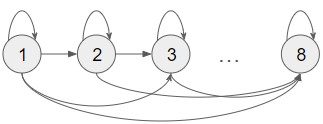

Notes:

* Attention is a communication mechanism. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
* There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
* Each example across batch dimension is of course processed completely independently and never "talk" to each other
* In an "encoder" attention block just delete the single line that does masking with tril, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
* "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
* "Scaled" attention additional divides wei by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

In [ ]:
# version 4 - self-attention
torch.manual_seed(1337)
B,T,C=4, 8, 32
x = torch.randn(B,T,C)

# implement a single head of the self-attention
head_size=16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x) # (B,T,16)
q = query(x) # (B,T,16)
v = value(x) # (B,T,16)
# wei is the affinity between k and q:
wei = q @ k.transpose(-2, -1) # (B,T,16)@(B,16,T)->(B,T,T)
#wei = torch.zeros((T,T))

tril = torch.tril(torch.ones(T,T))
# we don't need the following line in the encoder block. It's needed in decoder block.
wei = wei.masked_fill(tril==0, float('-inf')) # cannot communicate with future
wei = F.softmax(wei, dim=-1) # softmax takes ln(), then average

# out = wei@x # (B,T,C)
out = wei@v # (B,T,T)@(B,T,16)->(B,T,16)

In [ ]:
wei.shape, out.shape

(torch.Size([4, 8, 8]), torch.Size([4, 8, 16]))

In [ ]:
wei[0], out[0]

(tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
         [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
         [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
         [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
        grad_fn=<SelectBackward0>),
 tensor([[-0.1571,  0.8801,  0.1615, -0.7824, -0.1429,  0.7468,  0.1007, -0.5239,
          -0.8873,  0.1907,  0.1762, -0.5943, -0.4812, -0.4860,  0.2862,  0.5710],
         [ 0.6764, -0.5477, -0.2478,  0.3143, -0.1280, -0.2952, -0.4296, -0.1089,
          -0.0493,  0.7268,  0.7130, -0.1164,  0.3266,  0.3431, -0.0710,  1.2716],
         [ 0.4823, -0.1069, -0.40

In [ ]:
# why divide by sqrt(head_size)?
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size ** -0.5
k.var(), q.var(), wei.var()

(tensor(1.0449), tensor(1.0700), tensor(1.0918))

Without the scaline, wei.var() is 17.4... around the value of head_size. When doing softmax, we want the input values to be diffused, otherwise, the softmax will spike on the peak values and become one-hot. So we scale wei to make it unit Gaussian.

## Skip / Resudual connection

Originated from paper [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385)

In backprop, addition distributes the gradient equally to each path/branch. So the skip connection is a information superhighway for gradient to travel from supervision (loss) back to the input unimpeded. It dramatically helps with optimisation.

## Putting it together
<img src='https://miro.medium.com/v2/resize:fit:720/format:webp/1*BHzGVskWGS_3jEcYYi6miQ.png' width='400px'>

Out implementation only has decoder, no encoder or the cross-attention block.

In [ ]:
batch_size=32
block_size=8
max_iters=5000
eval_interval=500
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
emb_dim = 32 # embedding dimensions
head_size=None

In [ ]:
@torch.no_grad()
def estimate_loss():
  out={}
  model.eval()
  for split in ['train', 'val']:
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      X, Y = get_batch(split)
      logits, loss = model(X, Y)
      losses[k] = loss.item()
    out[split] = losses.mean()
  model.train()
  return out

In [ ]:
class Head(nn.Module):
  """Single head self-attention
  """
  def __init__(self, head_size):
    super().__init__()
    self.key = nn.Linear(emb_dim, head_size, bias=False)
    self.query = nn.Linear(emb_dim, head_size, bias=False)
    self.value = nn.Linear(emb_dim, head_size, bias=False)
    # since tril is not a native torch Module member, we use register_buffer
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

  def forward(self, x):
    """x is (B,T,C)
    """
    B,T,C=x.shape
    k = self.key(x) # (B,T,H) where H is head_size
    q = self.key(x) # (B,T,H)
    v = self.key(x) # (B,T,H)
    _,_,H = k.shape
    wei = q @ k.transpose(-2, -1) * H ** -0.5 # (B,T,H)@(B,H,T)->(B,T,T)
    # the [:T,:T] is necessary as x can be (1,1,C) during inference
    wei = wei.masked_fill(self.tril[:T,:T]==0, float('-inf')) # (B,T,T)
    wei = F.softmax(wei, dim=-1) # (B,T,T)
    out = wei @ v # (B,T,T)@(B,T,H)->(B,T,H)
    return out

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList( [Head(head_size) for _ in range(num_heads)] )
    # add another projection layer for going back to the residual pathway
    self.proj = nn.Linear(emb_dim, emb_dim)

  def forward(self, x):
    out = torch.cat( [h(x) for h in self.heads], dim=-1 )
    return self.proj(out)

In [ ]:
class FeedForward(nn.Module):
  """After self-attention (which communicates among tokens), the feed forward
  layer in Transformer allows the tokens/nodes to think indivicually before
  output layer.
  """
  def __init__(self, n_embed):
    super().__init__()
    self.net = nn.Sequential(
        # in Transformer whitepaper, the FFN inner layer dim is 2048, the input
        # dim is 512, i.e. 4 times the input dim. So we do the same here.
        nn.Linear(n_embed, 4 * n_embed),
        nn.ReLU(),
        # add another projection layer for going back to the residual pathway
        nn.Linear(4 * n_embed, n_embed),
    )

  def forward(self, x):
    return self.net(x)

In [ ]:
class Block(nn.Module):
  def __init__(self, n_embed, n_heads):
    super().__init__()
    self.sa_heads = MultiHeadAttention(n_heads, n_embed//n_heads)
    self.ffwd = FeedForward(n_embed)
    self.ln1 = nn.LayerNorm(n_embed)
    self.ln2 = nn.LayerNorm(n_embed)

  def forward(self, x):
    x = x + self.sa_heads( self.ln1(x) )
    x = x + self.ffwd( self.ln2(x) )
    return x

In [ ]:
class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    """with Wevenet, the dim can be 2-dimensional.
    """
    self.eps=eps
    self.momentum = momentum
    self.training = True

    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    """with Wavenet, x can be 3-dimensional (B,V,C), instead of 2 (B,V*C).
    for 3-dim x, we want to do the mean and var along the 1st 2 dimensions,
    i.e. x.view(-1, last_dim).mean(dim=0, keepdim=True)
    torch's mean can specify the dim as tuple, so we can use (0,1) as the dim
    when calling mean, and achieve the same.
    """
    if self.training:
      if x.ndim==2:
        dim=0
      if x.ndim==3:
        dim=(0,1)
      xmean = x.mean(dim, keepdim=True)
      xvar = x.var(dim, keepdim=True)
      with torch.no_grad():
        self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
        self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
    else:
      xmean = self.running_mean
      xvar = self.running_var

    x_hat = (x - xmean) / (xvar + self.eps)**0.5
    self.out = self.gamma * x_hat + self.beta

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

In [ ]:
torch.manual_seed(1337)
module = BatchNorm1d(100)
x = torch.randn(32, 100) # batch 32, of 100-dim vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [ ]:
# batch norm makes each node unit-Gaussian across the batch (dim 0).
x.var(dim=0), x.mean(dim=0), x.std(dim=0)

(tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]),
 tensor([-7.4506e-09,  7.4506e-08,  1.1176e-08,  2.7940e-09,  3.7253e-09,
          2.2352

The implementation of LayerNorm is same as BatchNorm, except for when calculating the mean() and variance, we use dim 1 instead of 0.

Also, we don't need to maintain the batch-wide running means and running var during training.

Note, unlike in the original whitepaper, nowadays, we apply the LayerNorm before the transformation. This is called per-norm formulation.

In [ ]:
class LayerNorm:
  def __init__(self, dim, eps=1e-5):
    """with Wevenet, the dim can be 2-dimensional.
    """
    self.eps=eps

    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    """with Wavenet, x can be 3-dimensional (B,V,C), instead of 2 (B,V*C).
    for 3-dim x, we want to do the mean and var along the 1st 2 dimensions,
    i.e. x.view(-1, last_dim).mean(dim=0, keepdim=True)
    torch's mean can specify the dim as tuple, so we can use (0,1) as the dim
    when calling mean, and achieve the same.
    """
    if x.ndim==2:
      dim=1       # chagne to dim=1 for layer norm
    if x.ndim==3:
      dim=(1,1)   # chagne to dim=1 for layer norm
    xmean = x.mean(dim, keepdim=True)
    xvar = x.var(dim, keepdim=True)

    x_hat = (x - xmean) / (xvar + self.eps)**0.5
    self.out = self.gamma * x_hat + self.beta

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

In [ ]:
torch.manual_seed(1337)
module = LayerNorm(100)
x = torch.randn(32, 100) # batch 32, of 100-dim vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [ ]:
# batch norm makes each node unit-Gaussian across the batch (dim 1).
x.var(dim=1), x.mean(dim=1), x.std(dim=1)

(tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000]),
 tensor([-9.5367e-09, -2.3842e-09, -2.0266e-08,  1.7881e-08,  1.6689e-08,
          9.8348e-09,  4.7684e-09,  1.9073e-08, -1.4305e-08, -4.7684e-09,
         -1.3113e-08, -5.9605e-09,  0.0000e+00, -7.1526e-09, -2.0266e-08,
          7.0035e-09, -1.2815e-08,  1.7881e-08,  6.5565e-09, -4.7684e-09,
          9.5367e-09, -3.5763e-09, -2.8610e-08,  4.7684e-09,  3.5763e-09,
         -7.1526e-09, -4.7684e-09,  0.0000e+00,  5.3644e-09, -1.1921e-08,
          4.7684e-09,  1.9073e-08]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000

In [ ]:
class BigramLanguageModel(nn.Module):
  """The Bigram model only looks at 1 character to predict the next.
  """
  def __init__(self):
    super().__init__()
    # lookup table of logits of character and its following character
    # nn.Embedding manpage: This module is often used to store word embeddings
    # and retrieve them using indices. The input to the module is a list of
    # indices, and the output is the corresponding word embeddings.
    self.token_embedding_table = nn.Embedding(vocab_size, emb_dim)
    self.position_embedding_table = nn.Embedding(block_size, emb_dim)

    #self.sa_head = Head(emb_dim) # make the head_size same as emb_dim
    # self.sa_heads = MultiHeadAttention(4, emb_dim // 4) # 4 heads of 8-dim'l self-attention
    # self.ffwd = FeedForward(emb_dim)
    self.blocks = nn.Sequential(
         Block(emb_dim, 4),
         Block(emb_dim, 4),
         Block(emb_dim, 4),
         nn.LayerNorm(emb_dim),
    )

    self.lm_head = nn.Linear(emb_dim, vocab_size)

  def forward(self, idx, targets=None):
    """idx and targets are both (B, T) tensor of integers
    returns logits of (B,T,C) (C is channel, here it's same as emb_dim)
    """
    B, T = idx.shape

    tok_emb = self.token_embedding_table(idx) # (B,T,C=emb_dim)
    pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
    x = tok_emb + pos_emb # (B,T,C)

    # x = self.sa_head(x) # (B,T,H) here H==C
    # x = self.sa_heads(x) # (B,T,C)
    # x = self.ffwd(x) # (B,T,C)
    x = self.blocks(x)

    logits = self.lm_head(x) # (B,T,C)

    if targets is None:
      loss=None
    else:
      # reshape to fit into the torch's cross_entropy function
      B,T,C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T) # or -1
      loss = F.cross_entropy(logits, targets)
    return logits, loss

  def generate(self, idx, max_new_tokens):
    """idx is (B,T) array of vocab indices in current context
    max_new_tokens - number of tokens to generate
    return a list of indices of the predicted tokens (from vocab)
    """
    for _ in range(max_new_tokens):
      # in case idx is too long, we chop it to the last block_size of tokens
      idx_cond = idx[:, -block_size:]
      logits, _ = self(idx_cond) # ignore the loss since we are in inference
      # we are interested in the last token in the time-series, so only work on that
      probs = F.softmax(logits[:, -1, :], dim=-1) # (B, C)
      idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
      # append the sampled index to the running sequence
      idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
    return idx

In [ ]:
model = BigramLanguageModel()
m = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# training
for iter in range(max_iters):

  # every once in a while evaluate the loss on train and val datasets
  if iter % eval_interval == 0:
    losses = estimate_loss()
    print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

  xb, yb = get_batch('train')
  logits, loss = m(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()
print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

step 0: train loss 4.3675, val loss 4.3653
step 500: train loss 2.4852, val loss 2.4732
step 1000: train loss 2.3710, val loss 2.3722
step 1500: train loss 2.2787, val loss 2.2967
step 2000: train loss 2.2442, val loss 2.2609
step 2500: train loss 2.1963, val loss 2.2406
step 3000: train loss 2.1770, val loss 2.2173
step 3500: train loss 2.1605, val loss 2.1799
step 4000: train loss 2.1271, val loss 2.1663
step 4500: train loss 2.1192, val loss 2.1833
step 4999: train loss 2.1192, val loss 2.1833


In [ ]:
# inference
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))



YCIOLIORD:
Tcown,
The lay ble

Hist my be toe.
Shirs I Muchaveanss:
Wanthir usqurt ther cedelassanes with my.


DEENY I IIN Thave some fort heart mal; dill, at miree senecin;
Stist in ovets, and the noper.

Wan I elplind thave thuse courvey:
Sup; ais all, yean's naus mamopetelaves
Mometll, demethak
To Wind tourt evibys the moldstion and hime sto-of gremeste
That dantert,
If son; igr therf thre male onth,
Mad sir, I Sometry I sop!

Herblis:
Sadst Wace Eght thisin cour ay and
Hiry thelsen thou his nepens, and griting I on I that
That heyser--ponges.

SICING Sand thouse lines the well ome.


CORINIUp:
Itst
Dthas lome
Itias detlul wath.

LARIOPEAB:
Haly to imip soce of's cok heit some so not heare fell tas nyibet' loovers!

Rour no duche nee, our as and batake bath whill
's am s sleve buml nom,
Whos well nooth ighticks hIneard?
Theill
My thean'en,
Thus?

Groiveth oour iund thouning these man iplytanou what thave thers,
sterel olbker of soo O
Ford RIIf Bwat dotive wout it fore;
To knot ou

# Scale up

added [dropouts](https://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf), changed hyper-param

Train this on TPU/GPU.

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

batch_size=64   # 16
block_size=256  # 32
max_iters=5000
eval_interval=100
lr = 3e-4       # 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
emb_dim = 384   # 64 # embedding dimensions
n_heads = 6     # 4
n_blocks = 6    # 4
dropout = 0.2   # 0.0

torch.manual_seed(1337)

def get_batch(split='train'):
  """split is one of 'train', 'val'
  """
  data = data_train if split=='train' else data_val
  batch_ix = torch.randint(0, len(data)-block_size, (batch_size,))
  x = torch.stack([data[i:i+block_size] for i in batch_ix])
  y = torch.stack([data[i+1:i+block_size+1] for i in batch_ix])
  x, y = x.to(device), y.to(device)
  return x, y

@torch.no_grad()
def estimate_loss():
  out={}
  model.eval()
  for split in ['train', 'val']:
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      X, Y = get_batch(split)
      logits, loss = model(X, Y)
      losses[k] = loss.item()
    out[split] = losses.mean()
  model.train()
  return out

class Head(nn.Module):
  """Single head self-attention
  """
  def __init__(self, head_size):
    super().__init__()
    self.key = nn.Linear(emb_dim, head_size, bias=False)
    self.query = nn.Linear(emb_dim, head_size, bias=False)
    self.value = nn.Linear(emb_dim, head_size, bias=False)
    # since tril is not a native torch Module member, we use register_buffer
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    """x is (B,T,C)
    """
    B,T,C=x.shape
    k = self.key(x) # (B,T,H) where H is head_size
    q = self.key(x) # (B,T,H)
    v = self.key(x) # (B,T,H)
    _,_,H = k.shape
    wei = q @ k.transpose(-2, -1) * H ** -0.5 # (B,T,H)@(B,H,T)->(B,T,T)
    # the [:T,:T] is necessary as x can be (1,1,C) during inference
    wei = wei.masked_fill(self.tril[:T,:T]==0, float('-inf')) # (B,T,T)
    wei = F.softmax(wei, dim=-1) # (B,T,T)
    wei = self.dropout(wei)
    out = wei @ v # (B,T,T)@(B,T,H)->(B,T,H)
    return out

class MultiHeadAttention(nn.Module):
  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList( [Head(head_size) for _ in range(num_heads)] )
    # add another projection layer for going back to the residual pathway
    self.proj = nn.Linear(emb_dim, emb_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    out = torch.cat( [h(x) for h in self.heads], dim=-1 )
    out = self.dropout(self.proj(out))
    return out

class FeedForward(nn.Module):
  """After self-attention (which communicates among tokens), the feed forward
  layer in Transformer allows the tokens/nodes to think indivicually before
  output layer.
  """
  def __init__(self, n_embed):
    super().__init__()
    self.net = nn.Sequential(
        # in Transformer whitepaper, the FFN inner layer dim is 2048, the input
        # dim is 512, i.e. 4 times the input dim. So we do the same here.
        nn.Linear(n_embed, 4 * n_embed),
        nn.ReLU(),
        # add another projection layer for going back to the residual pathway
        nn.Linear(4 * n_embed, n_embed),
        nn.Dropout(dropout),
    )

  def forward(self, x):
    return self.net(x)

class Block(nn.Module):
  def __init__(self, n_embed, n_heads):
    super().__init__()
    self.sa_heads = MultiHeadAttention(n_heads, n_embed//n_heads)
    self.ffwd = FeedForward(n_embed)
    self.ln1 = nn.LayerNorm(n_embed)
    self.ln2 = nn.LayerNorm(n_embed)

  def forward(self, x):
    x = x + self.sa_heads( self.ln1(x) )
    x = x + self.ffwd( self.ln2(x) )
    return x

class BigramLanguageModel(nn.Module):
  """The Bigram model only looks at 1 character to predict the next.
  """
  def __init__(self):
    super().__init__()
    # lookup table of logits of character and its following character
    # nn.Embedding manpage: This module is often used to store word embeddings
    # and retrieve them using indices. The input to the module is a list of
    # indices, and the output is the corresponding word embeddings.
    self.token_embedding_table = nn.Embedding(vocab_size, emb_dim)
    self.position_embedding_table = nn.Embedding(block_size, emb_dim)
    self.blocks = nn.Sequential(*[Block(emb_dim, n_heads) for _ in range(n_blocks)])
    self.ln_f = nn.LayerNorm(emb_dim) # final layerNorm
    self.lm_head = nn.Linear(emb_dim, vocab_size)

  def forward(self, idx, targets=None):
    """idx and targets are both (B, T) tensor of integers
    returns logits of (B,T,C) (C is channel, here it's same as emb_dim)
    """
    B, T = idx.shape

    tok_emb = self.token_embedding_table(idx) # (B,T,C=emb_dim)
    pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
    x = tok_emb + pos_emb # (B,T,C)
    x = self.blocks(x) # (B,T,C)
    x = self.ln_f(x) # (B,T,C)

    logits = self.lm_head(x) # (B,T,C=vocab_size)

    if targets is None:
      loss=None
    else:
      # reshape to fit into the torch's cross_entropy function
      B,T,C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T) # or -1
      loss = F.cross_entropy(logits, targets)
    return logits, loss

  def generate(self, idx, max_new_tokens):
    """idx is (B,T) array of vocab indices in current context
    max_new_tokens - number of tokens to generate
    return a list of indices of the predicted tokens (from vocab)
    """
    for _ in range(max_new_tokens):
      # in case idx is too long, we chop it to the last block_size of tokens
      idx_cond = idx[:, -block_size:]
      logits, _ = self(idx_cond) # ignore the loss since we are in inference
      # we are interested in the last token in the time-series, so only work on that
      probs = F.softmax(logits[:, -1, :], dim=-1) # (B, C)
      idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
      # append the sampled index to the running sequence
      idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
    return idx

model = BigramLanguageModel()
m = model.to(device)
print( sum(p.numel() for p in model.parameters())/1e6, "M parameters." )
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# training
def train(max_iters):
  for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val datasets
    if iter % eval_interval == 0 or iter == max_iters-1:
      losses = estimate_loss()
      print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


  torch.save(m.state_dict(), 'shakespear_params.pth')

10.788929 M parameters.


In [ ]:
# break the training loop to multiple smaller loops
train(3000)

step 0: train loss 4.2607, val loss 4.2597

step 100: train loss 2.4853, val loss 2.5009

step 200: train loss 2.4615, val loss 2.4910

step 300: train loss 2.4461, val loss 2.4674

step 400: train loss 2.4303, val loss 2.4591

step 500: train loss 2.4085, val loss 2.4394

step 600: train loss 2.3881, val loss 2.4176

step 700: train loss 2.3368, val loss 2.3710

step 800: train loss 2.2417, val loss 2.2925

step 900: train loss 2.1717, val loss 2.2355

step 1000: train loss 2.1064, val loss 2.1934

step 1100: train loss 2.0322, val loss 2.1299

step 1200: train loss 1.9551, val loss 2.0734

step 1300: train loss 1.8858, val loss 2.0221

step 1400: train loss 1.8097, val loss 1.9566

step 1500: train loss 1.7608, val loss 1.9230

step 1600: train loss 1.7185, val loss 1.8918

step 1700: train loss 1.6713, val loss 1.8346

step 1800: train loss 1.6420, val loss 1.8138

step 1900: train loss 1.6104, val loss 1.7894

step 2000: train loss 1.5839, val loss 1.7573

step 2100: train loss 1.5

In [ ]:
# train for another 3000 loops
train(3000)

step 0: train loss 1.4247, val loss 1.6341
step 100: train loss 1.4234, val loss 1.6354
step 200: train loss 1.4250, val loss 1.6334
step 300: train loss 1.4257, val loss 1.6337
step 400: train loss 1.4244, val loss 1.6364
step 500: train loss 1.4241, val loss 1.6350
step 600: train loss 1.4220, val loss 1.6366
step 700: train loss 1.4233, val loss 1.6361
step 800: train loss 1.4241, val loss 1.6347
step 900: train loss 1.4251, val loss 1.6315
step 1000: train loss 1.4248, val loss 1.6372
step 1100: train loss 1.4259, val loss 1.6313
step 1200: train loss 1.4250, val loss 1.6315
step 1300: train loss 1.4242, val loss 1.6315
step 1400: train loss 1.4234, val loss 1.6312
step 1500: train loss 1.4233, val loss 1.6341
step 1600: train loss 1.4259, val loss 1.6349
step 1700: train loss 1.4244, val loss 1.6356
step 1800: train loss 1.4244, val loss 1.6321
step 1900: train loss 1.4273, val loss 1.6333
step 2000: train loss 1.4250, val loss 1.6325
step 2100: train loss 1.4247, val loss 1.6328


## Load and inference

In [ ]:
saved_filename = '../input/gpt2_shakespear/pytorch/default/1/shakespear_params_3000.pth'
model = BigramLanguageModel()
model.load_state_dict(torch.load(saved_filename))
m = model.to(device)

# inference
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

/tmp/ipykernel_36/3072692993.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(saved_filename))



Save than again up on, if more the far with your tongue;
Makes nayw know not was and Catbbroke.
GEor.

CLARENCE:
Come, what's love hear desight means,
Tho, I leave wisholy shome I may to royw,
And not all his fallower. Warwick, farewell,
And blundersile me both to Gentlems, Carion,
Though Comn Hastings would father?

CORIOLANUS:
Know lord, lows, And granthing him.
What me, my Signera Willingelanst of him dame of qudet,
With her should by rot me.

CORIOLANUS:
Mird!
This All he's ress mine honous me.
But An lest before presseque' war'd heaven it at,
A when to his hemit appronabear is, so por gentleman,
Or sen it it All up: one metimp, facter of bid
The prisof friencal which shall roon trabved to hithers suims he
ceving hands honour sunder to strittly.
ANGELO:
More 'eward parly in braquestited repith royle.

DUKE VINCENTIO:
Well, enver the news?

JULIET:
Both I wrong poor the tormers of wes the thousand
To hither the returph of Marcius seeR: mett cannot found:
Ten, frown did hend dukning

In [ ]:
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


Tis sweepe no alonef.

DUKE OF YORK:
Runnight! Norses my besset and our short,
Camoher headrless, sove as as truest, and
empentunce the goove, for Rathage one behing misch
the trotom a morrus, I was a love off hath
To death make of be be ouragus anys gatin a shall:
not tut unthat Cusin: I help time our bid,
And but vaniam to thee, I day mustorn:
Cheesbel, none of none Anainst of mine!
Resoon, I know but her him too rather's gone.
Why chosine in my quest for, first comme.

FRIAR LAURENCE:
Aun strew he heaven all in I cage bee within
For my so with me, ground Keesting on Rives intly BaR.
I prive shame FRICHARD:
God slave news ut, add here high as the death?
I will: Rancaus, it that hath honourset;
With his kinsming, and in the what star's his;
The own from the dansethling up
ar of my trespeak'd: retther of brother they
vanious of my state, whereof prouse thee! for to hate.

CATISUS:
Not sould with not yourselves thee honess
Evongs by dill-letting myst it:
And poor be me now the gentler 

Inference result when loss was 1.4-1.6:
<pre>
She will  grown of Stices
Thre Pricius there her issue to'er, it hence,
Firsth out helpt on her designg
There all liverend ught be ring he shall
I the movenward the graves person of afiry:
Gold my in: wilthor, may on' this be heaven at day,
Sraigh'd the premut cave of Prons,
Yet temptinate,
Hag their rablic surp ourselved obey. God our him,
A cove thou wneeded hast his worship; here, whose would have,
dels bars upase, this Hensmis my I do your mine.
A were had is have yours camrcibled me sleapn'd equiet,
Twes can I she causled. Brink all I companirfullouds,
tre knows known wray in inteor,
his her, and that make sust wouldst to stays,
To a ndeed for that viole with me pennizents of my life:
True not.

NORTURS:
And, I do love have not, must give thoughn'd rell, west,
Inatheron what command out day the four thee
hr if thing away troward droust: then fall them you.

BUCOLIO:
I'll know to hereb'd of your roficining'd,
As what give woful king Bengeo, his love.

QUEEN ELIZABETH:
Not with very with hon, tell from fear. Richmond;
See Marcis of York, whilh stragg it if after,
With fialin I yours lord my Lord Margun with his should wonds,
Mittle most to be what his proud desped's
And rise good but his love, doth not plud not, brille.
Why will ministining Adlow of yours thands.

HASTRINGS:
This do be to the wis dance in the bear.
Your, in with the mod boh that I mean him know,
hath in Is pard abuneled himsent on, his
make that's makes was I have and be prayed;
Annor me not common near be confotsce of andel,
But be a fesil strange, and to re,
But his out loy: well, sing the make carged on such toge.

NORFOok, fasagon, Sir Gavet, stand thosows stong he
reash yours our countrupten, have strrow; let me
Engle midnet thou Rown me slew up, not orden hence
To tell and a I hap,
Her not fater' pluke herd so I have revint degreate.

CAMIDIUS:
So, all a we reporer the plect me: and beher shall'd
Our hyrnight.

BARNARD:
O surCUS:
Let whom he the was a too desteritions.

3EDWARD PARDISS VI
</pre>